## 介绍



## 导入数据

第一步需要引入必要的包

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import jieba
import math
import os

%matplotlib inline

导入数据文件 `items.csv`, 并命名为`jobs`

In [2]:
file_path = './data'
abs_paths = [ os.path.abspath('./data/%s'% item) for item in os.listdir(file_path) if re.compile('.+\.csv$').match(item) ]
data_list = [ pd.read_csv(file_name) for file_name in abs_paths]
jobs  = pd.concat(data_list);
jobs = jobs.drop_duplicates(subset='job_id');


## 处理数据

按顺序保留如下列，存入新的变量`n_jobs`中：

```
['job_id', 'job_title','comp_name','comp_size','address','salary_min','salary_max','experience','education','job_desp']

```

In [3]:
n_jobs = jobs[['job_id', 'job_title','comp_name','comp_size','address','salary_min','salary_max','experience','education','job_desp']]

接下来的数据处理：
- 将`experience`需要的工作年限变为数值型
- 新增一列为平均工资，从最小和最大工资计算得出

讲道理，对于薪水而言，常识上有如下影响信息：
- experience 工作经验，工作2～3年的人往往比没有经验的新人更有吸引力
- job_desp 掌握的技能要求或者工作内容的要求越复杂，薪水越好。因为更复杂的工作内容需要有能力的人
- comp_size 公司规模，大公司有实力开出很好的薪水以吸引更多人才
- job title也有关系，比如机器学习科学家、机器学习专家肯定比机器学习开发工资高吧
- address 公司的位置也有关系，比如陆家嘴位置的公司，经济实力肯定也很强，太偏的地方员工也不愿意去
- education 学历要求，要求研究生以及以上的公司，门槛就有了，工资肯定有吸引力才行

总结一下，就是个人实力（工作经验，掌握的技能、教育背景）和公司实力（公司规模、公司位置、发布职位要求）综合决定了薪水的多少。以上都是定性的常识上的猜测，具体情况如何，有没有反转的情况的发生还得结合具体数据分析。



对此，有如下问题值得分析：

- 分析下工作年限需要的分布
- 分析下工作年限跟薪水之间的关系
- 分析下工作职责描述中提到最多的技能项
- 对于发布职位的公司，在地理上如何分布？是不是可以做一个类似于房价地图的魔都薪水地图？

In [4]:
def changeExp(x):
    pt_s = '(\d+)年以上经验'
    pt = re.compile(pt_s)
    if pt.match(x):
        gg = pt.search(x)
        return int(gg.group(1))
    elif x == '经验不限':
        return 0
    else:
        x = -1
        
n_jobs['experience'] = n_jobs['experience'].apply(changeExp);
n_jobs = n_jobs.set_index('job_id')


/Users/fr4nk.yang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


#### 计算平均工资

In [5]:
n_jobs['salary_avg'] = n_jobs[['salary_min', 'salary_max']].mean(axis=1)

### 从数据本身来看

使用 describe 函数，查看数据的大致情况。

首先分析，数据的类型，比如是离散or连续的，数值or字符型等等。

#### 数据基本情况

In [59]:
n_jobs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4054 entries, https://www.liepin.com/job/1910030651.shtml to https://www.liepin.com/a/9930387.shtml
Data columns (total 10 columns):
job_title     4054 non-null object
comp_name     1489 non-null object
comp_size     454 non-null object
address       1489 non-null object
salary_min    3688 non-null float64
salary_max    3688 non-null float64
experience    4054 non-null int64
education     4054 non-null object
job_desp      4054 non-null object
salary_avg    3688 non-null float64
dtypes: float64(3), int64(1), object(6)
memory usage: 348.4+ KB


可以得出一些初步事实：
- 数据有 4054 条
- 其中非猎头的职位信息有 1489 条, ~37%
- 给出具体薪资水平有 3688 条（~91%），其余是面谈
- 全都给出了经验要求、工作名称、学历和职责描述

In [60]:
n_jobs.describe(include=['O'])

,job_title,comp_name,comp_size,address,education,job_desp
count,4054,1489,454,1489,4054,4054
unique,2419,474,8,642,7,3795
top,算法工程师,美团点评,公司规模：100-499人,公司地址：上海市浦东新区金科路2889号 长泰广场C座 7楼,本科及以上,职位描述：1 、负责公司产品推广、门店数据等分析和录入；2、负责区域内客户关系的维护及日常对...
freq,111,70,210,51,1447,8


得出一些初步结果：
- 算法工程师，也就是说做机器学习的title在公司中大多为算法工程师
- 发布工作最多的公司是 美团点评
- 其中公司规模，绝大多数为100-499人
- 对求职者学历要求，最常见的是统招本科

In [61]:
n_jobs.describe()

,salary_min,salary_max,experience,salary_avg
count,3688.000000,3688.000000,4054.000000,3688.000000
mean,35.423807,57.245390,3.398125,46.334599
std,25.638283,33.011069,1.879770,29.098551
min,3.000000,4.000000,0.000000,3.500000
25%,20.000000,36.000000,2.000000,30.000000
50%,30.000000,52.000000,3.000000,41.000000
75%,40.000000,70.000000,5.000000,55.000000
max,400.000000,460.000000,12.000000,430.000000


得出初步结论：
- 对机器学习、数据分析等方向的工作经验，平均要求是3.4年
- 薪水范围，25%起薪20w, 50%起薪是30w
- 起薪范围最大值50%在52w

#### 分析可分类字段

```python
job_title	comp_name	comp_size	address	education	job_desp
```

In [64]:
titles = n_jobs['job_title'].value_counts();
titles.head(30)

算法工程师        111
数据分析师         76
数据挖掘工程师       64
产品经理          59
产品总监          47
数据分析          41
运营总监          38
数据产品经理        31
高级数据分析师       28
高级算法工程师       27
数据科学家         24
推荐算法工程师       23
数据分析经理        23
大数据开发工程师      22
数据分析专家        22
高级产品经理        20
图像算法工程师       19
算法专家          19
机器学习算法工程师     17
大数据架构师        17
机器学习工程师       17
资深数据分析师       17
用户运营          16
数据挖掘专家        16
数据挖掘          16
用户运营经理        14
大数据工程师        13
模型分析          12
资深算法工程师       12
运营经理          10
Name: job_title, dtype: int64

In [65]:
comp_names = n_jobs['comp_name'].value_counts();
comp_names.head(30)

美团点评                 70
饿了么                  47
韩领科技                 40
携程                   34
阿里巴巴                 31
小红书                  24
中彦                   23
上海寻梦信息技术有限公司         18
透云物联网                16
达而观信息科技(上海)有限公司      15
上海宏鹿信息技术服务有限公司       15
腾讯                   14
上海鱼耀金融信息服务有限公司       14
触宝科技                 14
上海微盟                 13
聚力传媒上海               13
patsnap              12
平安科技                 12
哔哩哔哩弹幕网              11
华院                   11
Coupang China        11
小黑鱼科技有限公司            10
挚享科技(上海)有限公司关联公司     10
上海欣兆阳信息科技有限公司        10
我图网                  10
上海爱熙品牌管理有限公司          9
上海络策网络科技有限公司          9
Baidu                 9
帜讯信息                  9
工业互联网创新中心(上海)有限公司     9
Name: comp_name, dtype: int64

In [66]:
n_jobs['education'].value_counts().head(30)

本科及以上     1447
统招本科      1394
学历不限       501
硕士及以上      419
大专及以上      261
博士          31
MBA及以上       1
Name: education, dtype: int64

#### 分析数值型字段
```
salary_min	salary_max	experience
```


In [68]:
n_jobs['experience'].value_counts().head(30)

3     1497
5      919
2      690
1      321
0      175
8      161
4      137
6       67
10      44
7       41
12       2
Name: experience, dtype: int64

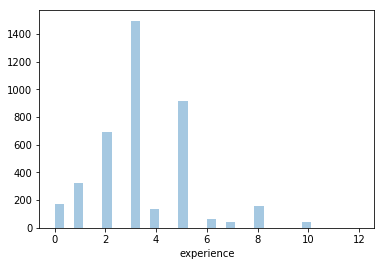

In [69]:
pp = sns.distplot(n_jobs['experience'], norm_hist=False, kde=False)

In [71]:
n_jobs['salary_min'].describe()

count    3688.000000
mean       35.423807
std        25.638283
min         3.000000
25%        20.000000
50%        30.000000
75%        40.000000
max       400.000000
Name: salary_min, dtype: float64

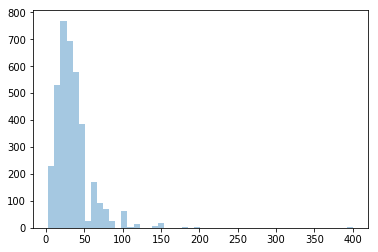

In [83]:
salarys = n_jobs[pd.notnull(n_jobs['salary_min'])].loc[:, ["salary_min"]];salarys.head(5)
sns.distplot(salarys, norm_hist=False, kde=False)

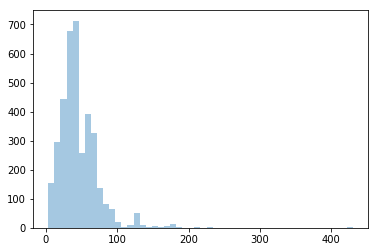

In [85]:
salary_maxs = n_jobs[pd.notnull(n_jobs['salary_avg'])].loc[:, ["salary_avg"]]
sns.distplot(salary_maxs, norm_hist=False, kde=False)

### 画图分析数据

#### 工作年限的需求分布

Text(0,0.5,u'Count')

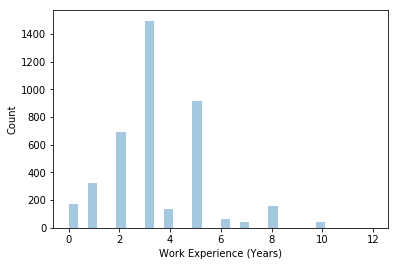

In [67]:
ax = sns.distplot(n_jobs['experience'], norm_hist=False, kde=False)
ax.set_xlabel('Work Experience (Years)')
ax.set_ylabel(u'Count')

#### 公司规模跟薪水的关系

In [57]:
comp_size_salary = n_jobs[['comp_size', 'salary_min', 'salary_max']].groupby('comp_size').mean().sort_values(by=['salary_min', 'salary_max'],ascending=True)

In [59]:
comp_size_salary

,salary_min,salary_max
comp_size,,
公司规模：1-49人,21.300000,37.750000
公司规模：500-999人,22.161616,41.070707
公司规模：2000-5000人,22.800000,39.066667
公司规模：1000-2000人,23.560000,41.280000
公司规模：100-499人,25.364486,43.548287
公司规模：10000人以上,26.459677,47.830645
公司规模：50-99人,26.910891,44.792079
公司规模：5000-10000人,30.200000,50.600000


In [74]:
def filter_nan(df):
    if df['comp_size'] is not None and df['salary_min'] is not None and df['salary_max'] is not None:
        return True
    else:
        return False
    
ss = n_jobs[['comp_size', 'salary_min', 'salary_max']].loc[filter_nan,:]; ss.head(5)
# gg = sns.FacetGrid(n_jobs, row="comp_size")
# gg = gg.map(plt.hist, ['salary_min', 'salary_max'])

KeyError: 'the label [True] is not in the [index]'

工作年限跟薪水的关系

In [33]:
salary_exp = n_jobs.groupby('experience').mean().reset_index()

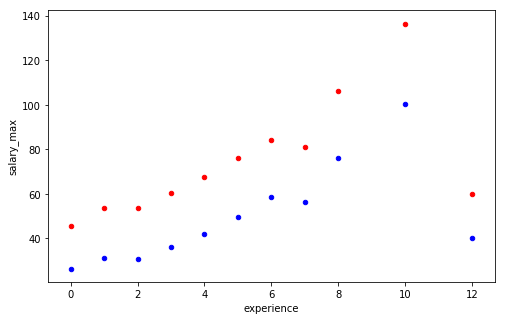

In [34]:
ax = salary_exp.plot( kind='scatter',x='experience',   y='salary_min', color='b', figsize=(8,5) )
salary_exp.plot(kind='scatter',x='experience',  y='salary_max', color='r', ax = ax)

plt.show()
